# 5. Patents Analysys

This Notebook shows how it's possible to analyse patents data related to Rome University programmatically, using the Dimensions API with Jupyter Notebooks. 


In [75]:
import dimcli
from dimcli.shortcuts import dslquery, dslqueryall, chunks_of
import time
import pandas as pd
from pandas.io.json import json_normalize
import plotly_express as px
from plotly.offline import init_notebook_mode # needed for exports 
init_notebook_mode(connected=True)

Dimensions data source are mined for organizations identifiers using GRID, the [Global Research Identifier Database](https://grid.ac/). So we can use GRID IDs to perform searches across all source in Dimensions. 

The GRID ID for Rome La Sapienza is [grid.7841.a](https://grid.ac/institutes/grid.7841.a). 


In [3]:
GRIDID = "grid.7841.a"

## Patents assigned, by year 

In [4]:
dslquery(f"""search patents where assignees.id="{GRIDID}" return patents""").stats 

Returned Patents: 20 (total = 558)


{'total_count': 558}

In [11]:
data = dslquery(f"""search patents where assignees.id="{GRIDID}" return patents limit 1000""")
df = data.as_dataframe() 

Returned Patents: 558 (total = 558)


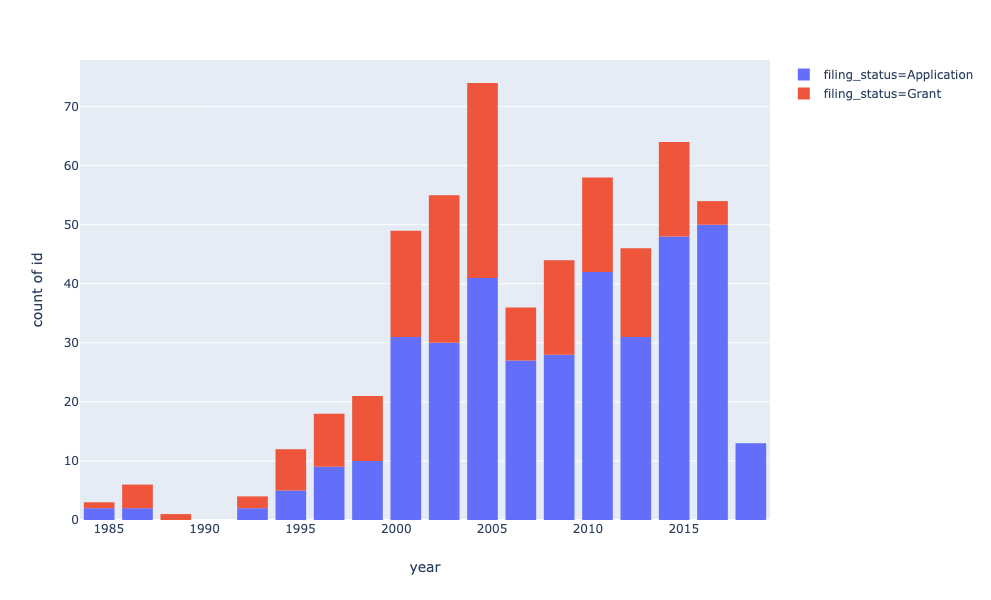

In [12]:
px.histogram(df, x="year", y="id", color="filing_status", hover_data=['assignee_names'])

## Patents co-assignees

In [58]:
df2 = json_normalize(data.patents, record_path=['assignees'], 
                     meta=["id", "year", "title"], errors='ignore', record_prefix='assignee_')
df2 = df2.rename(columns={"assignee_country_name" : "country"})
df2  = df2[df2['assignee_id'] != GRIDID] # remove Rome from data

In [59]:
df2.head()

,assignee_acronym,country,assignee_id,assignee_name,id,year,title
1,CNR,Italy,grid.5326.2,National Research Council,CA-2659681-A1,2007,PEPTIDE DERIVED FROM VASCULAR ENDOTHELIAL GROW...
2,IDI,Italy,grid.419457.a,Istituto Dermopatico dell'Immacolata,CA-2659681-A1,2007,PEPTIDE DERIVED FROM VASCULAR ENDOTHELIAL GROW...
9,UNC,United States,grid.10698.36,University of North Carolina at Chapel Hill,WO-2018187439-A1,2018,CRYOPRESERVATION METHOD
11,UNISI,Italy,grid.9024.f,University of Siena,EP-2195289-A2,2008,PYRROLE COMPOUNDS AS INHIBITORS OF MYCOBACTERI...
13,UNC,United States,grid.10698.36,University of North Carolina at Chapel Hill,US-9750770-B2,2015,Method of treating pancreatic and liver condit...


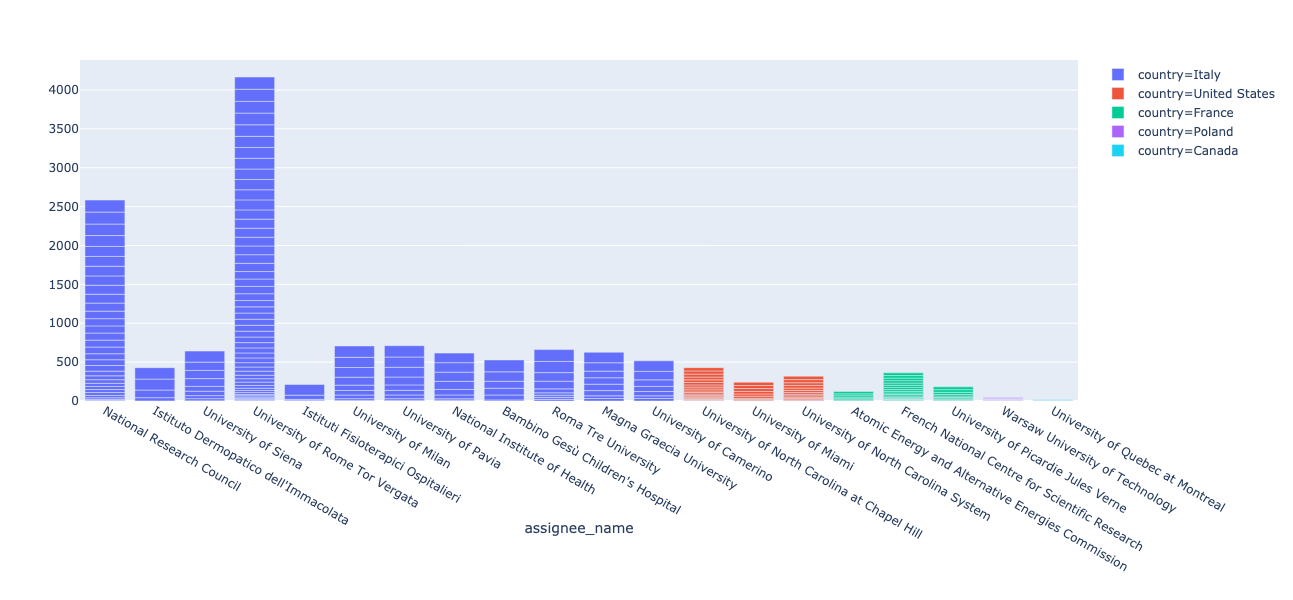

In [61]:
px.bar(df2.groupby('assignee_name').filter(lambda x: len(x) > 3), x="assignee_name", 
       color="country", hover_name="title", hover_data=["id"])

## Patents co-assignees by year and country

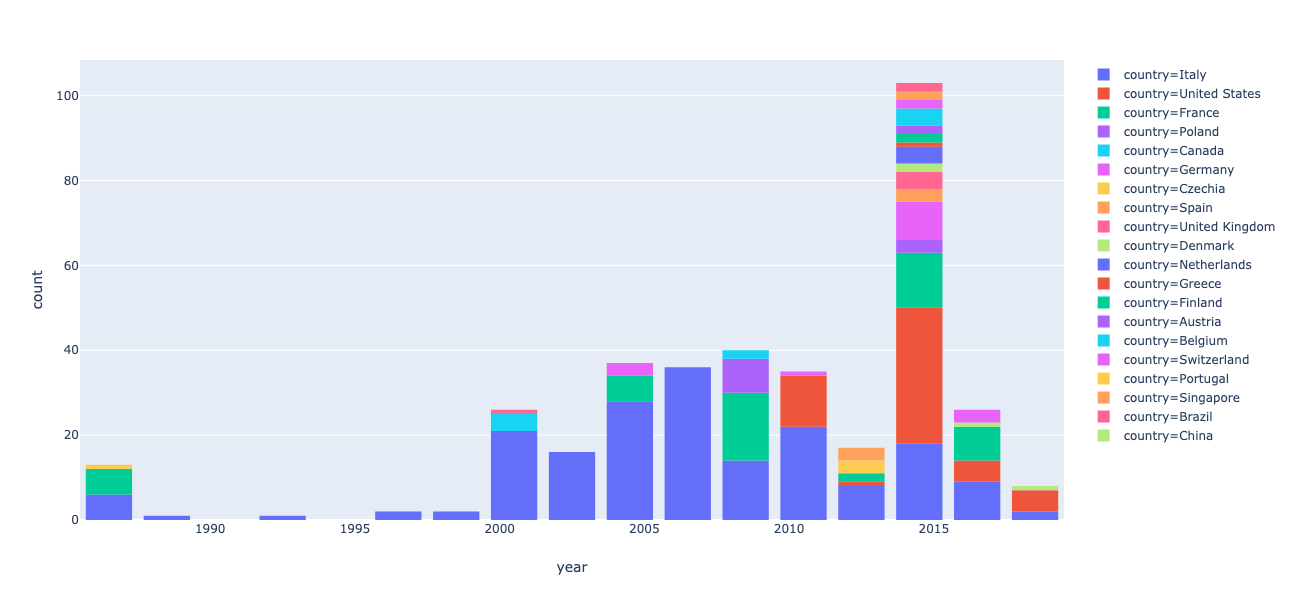

In [49]:
px.histogram(df2, x="year", color="country", hover_name="assignee_name", hover_data=['country'])


## Patents co-assignees distribution, by year, org name and country

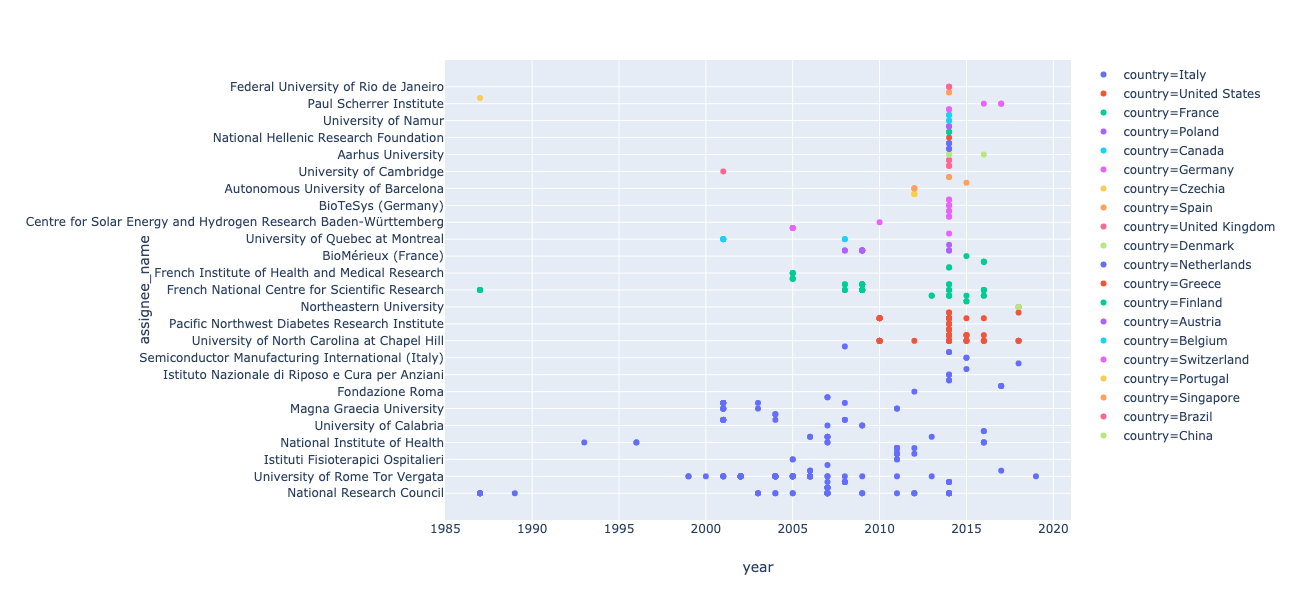

In [48]:
px.scatter(df2, x="year", y="assignee_name", height=600,
           color="country", hover_name="assignee_name", hover_data=['country'])

# Patents citing publications from Rome

Get a list of relevant publications - we don't take any recent publications as it's unlikely it'll be cited in patents!

In [80]:
pubs = dslqueryall(f"""search publications where research_orgs.id="{GRIDID}" and year in [2010:2015] return publications[basics]""")

1000 / 33729
2000 / 33729
3000 / 33729
4000 / 33729
5000 / 33729
6000 / 33729
7000 / 33729
8000 / 33729
9000 / 33729
10000 / 33729
11000 / 33729
12000 / 33729
13000 / 33729
14000 / 33729
15000 / 33729
16000 / 33729
17000 / 33729
18000 / 33729
19000 / 33729
20000 / 33729
21000 / 33729
22000 / 33729
23000 / 33729
24000 / 33729
25000 / 33729
26000 / 33729
27000 / 33729
28000 / 33729
29000 / 33729
30000 / 33729
31000 / 33729
32000 / 33729
33000 / 33729
33729 / 33729


In [81]:
dfpubs = pubs.as_dataframe()

Now extract all patents linked to the publications dataset previously created

Note: the patents query goes like this: `search patents where publication_ids in ["pub.1111511314", ...] return patents`

In [83]:

BATCHSIZE = 400

def run(pubs_ids):
    patents_out, n  = [], 0
    for chunk in chunks_of(pubs_ids, BATCHSIZE):
        temp = ','.join(['"{}"'.format(i) for i in chunk])
        data = dslquery(f"""search patents where publication_ids in [{temp}] return patents[basics] limit 1000""")
        patents_out += data.patents
        n += 1
        print("[log] Scanned publications: ", n*BATCHSIZE, " > Tot Patents found: ", len(data.patents))
        time.sleep(1)
    return patents_out
        
patents_list = run(list(dfpubs['id']))

Returned Patents: 4 (total = 4)
[log] Scanned publications:  400  > Tot Patents found:  4
Returned Patents: 5 (total = 5)
[log] Scanned publications:  800  > Tot Patents found:  5
Returned Patents: 2 (total = 2)
[log] Scanned publications:  1200  > Tot Patents found:  2
Returned Patents: 2 (total = 2)
[log] Scanned publications:  1600  > Tot Patents found:  2
Returned Patents: 2 (total = 2)
[log] Scanned publications:  2000  > Tot Patents found:  2
Returned Patents: 2 (total = 2)
[log] Scanned publications:  2400  > Tot Patents found:  2
Returned Patents: 2 (total = 2)
[log] Scanned publications:  2800  > Tot Patents found:  2
Returned Patents: 4 (total = 4)
[log] Scanned publications:  3200  > Tot Patents found:  4
Returned Patents: 1 (total = 1)
[log] Scanned publications:  3600  > Tot Patents found:  1
Returned Patents: 1 (total = 1)
[log] Scanned publications:  4000  > Tot Patents found:  1
Returned Patents: 7 (total = 7)
[log] Scanned publications:  4400  > Tot Patents found:  7
R

In [84]:
dfpatents = pd.DataFrame().from_dict(patents_list)
# save to CSV
dfpatents.to_csv("patents_citing_pubs.csv")
# preview top 3 rows
dfpatents.head(3)

,assignee_names,assignees,filing_status,granted_year,id,inventor_names,publication_date,times_cited,title,year
0,[SPHINGOTEC GMBH],NaN,Application,NaN,WO-2016170023-A1,"[BERGMANN, ANDREAS, MELANDER, OLLE]",2016-10-27,NaN,A METHOD FOR PREDICTING THE RISK OF INCIDENCE ...,2016
1,"[Purdue Pharma LP, PURDUE PHARMACEUTICAL PRODU...","[{'id': 'grid.418726.e', 'name': 'Purdue Pharm...",Grant,2018.0,US-9993482-B2,[Thomas Jorg Mehrling],2018-06-12,NaN,Pharmaceutical combination comprising a class ...,2015
2,"[Sunshire Lake Pharma Co Ltd, Sunshine Lake Ph...",NaN,Grant,2018.0,US-9957233-B1,[Ning Xi],2018-05-01,NaN,Process for preparing substituted quinolin-4-o...,2017


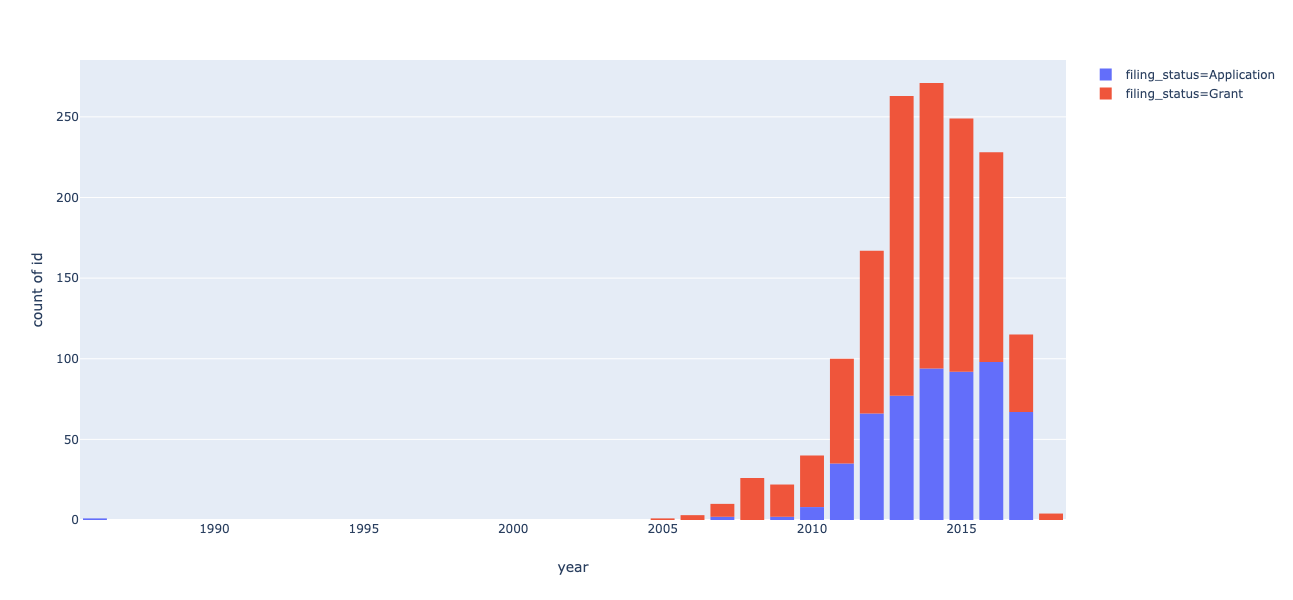

In [85]:
px.histogram(dfpatents, x="year", y="id", color="filing_status", hover_data=['assignee_names'])

---
# Activities

* Try analyzing the assigness data (like we did above) for this new 'referencing' set of patents. Does any interesting patter emerge?
* Try repeating the same analysis for a different organization listed in the [Global Research Identifier Database](https://grid.ac/)
* Try modifying the original query to discover more information about the research areas of patents (tip: you can use `FOR` categories for this, [see the docs](https://docs.dimensions.ai/dsl/data-sources.html#patents))

---
# Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 